In [1]:
pip install re

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [2]:
pip install textstat

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [5]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from textstat.textstat import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as vaderSentiment

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\patin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
# function to parse text (used regular expressions)
def parsed_text(input_tweet):
    regular_exp_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regular_exp_hash_tags = '@[\w\-]+'
    tweet = re.sub('\s+', ' ', input_tweet)
    tweet = re.sub(regular_exp_url, '', tweet)
    tweet = re.sub(regular_exp_hash_tags, '', tweet)
    return tweet

In [7]:
# function to tokenize tweet data
def tokenize_tweet_data(tweet_data):
    a = re.split("[^a-zA-Z]*", tweet_data.lower())
    tweet_data = " ".join(a).strip()
    stem = PorterStemmer()
    x = tweet_data.split()
    stem_tokens = [stem.stem(i) for i in x]
    return stem_tokens

In [8]:
# function to tokenize tweet using parts of speech
def tokenize_tweet_pos(tweet):
    a = re.split("[^a-zA-Z.,!?]*", tweet.lower())
    tweet = " ".join(a).strip()
    pos_tweet = tweet.split()
    return pos_tweet

In [9]:
# function to get the various counts
def get_twitter_counts(input_text_string):
    regular_exp_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    ct_tweet = re.sub('\s+', ' ', input_text_string)
    ct_tweet = re.sub(regular_exp_url, 'URL', ct_tweet)
    ct_tweet = re.sub('@[\w\-]+', 'MENTIONS', ct_tweet)
    ct_tweet = re.sub('#[\w\-]+', 'HASH_TAGS', ct_tweet)
    return ct_tweet.count('URL'), ct_tweet.count('MENTIONS'), ct_tweet.count('HASH_TAGS')

In [10]:
# funtion to extract features (feature engineering part)
def feature_extraction(tweet):
    feeling = predict_sentiment.polarity_scores(tweet)

    tokens_tweets = parsed_text(tweet)
    char_length = sum(len(w) for w in tokens_tweets)
    total_char_length = len(tweet)
    splits = len(tweet.split())
    word_count = len(tokens_tweets.split())
    syllables = textstat.syllable_count(tokens_tweets)
    a = (syllables + 0.001)
    b = (word_count + 0.001)
    syl_score = round(a / b, 4)
    split_tokens = set(tokens_tweets.split())
    unique_count = len(split_tokens)

    twitter_counts = get_twitter_counts(tweet)
    num_of_tweets_re_tweeted = 0
    if "rt" in tokens_tweets:
        num_of_tweets_re_tweeted = 1
        
# features        
    f_ = [syllables, syl_score, char_length, total_char_length, splits, word_count, unique_count,
          feeling['neg'], feeling['pos'], feeling['neu'], feeling['compound'], twitter_counts[2],
          twitter_counts[1], twitter_counts[0], num_of_tweets_re_tweeted]
    return f_

In [11]:
def feature_vector(input_string):
    features_ = []
    for feature in input_string:
        features_.append(feature_extraction(feature))
    return np.array(features_)

In [12]:
#reading input csv
df = pd.read_csv('labeled_data.csv')
df.head()
tweets = df.tweet
# used nltk stopwords
stopwords = nltk.corpus.stopwords.words("english")
# labeled data has RT (re-tweet)
stopwords.extend(["rt"])  
vector = TfidfVectorizer(tokenizer=tokenize_tweet_data, preprocessor=parsed_text, ngram_range=(1, 3),
                             stop_words=stopwords, use_idf=True, smooth_idf=False, norm=None,
                             decode_error='replace', max_features=10000, min_df=5, max_df=0.75)
warnings.simplefilter(action='ignore', category=FutureWarning)
score_tf_idf = vector.fit_transform(tweets).toarray()
z = vector.get_feature_names()
vocab = {v: j for j, v in enumerate(z)}
value_idf = vector.idf_
dict_ = {i: value_idf[i] for i in vocab.values()}
tweet_tags = []
for t in tweets:
    tokens = tokenize_tweet_pos(parsed_text(t))
    pos_tags = nltk.pos_tag(tokens)
    pos_tag_list = [x[1] for x in pos_tags]
    pos_tag_ = " ".join(pos_tag_list)
    tweet_tags.append(pos_tag_)
pos_vector = TfidfVectorizer(tokenizer=None, lowercase=False, preprocessor=None, ngram_range=(1, 3),
                                 stop_words=None, use_idf=False, smooth_idf=False, norm=None, decode_error='replace',
                                 max_features=5000, min_df=5, max_df=0.75)
pos_array = pos_vector.fit_transform(pd.Series(tweet_tags)).toarray()
x = pos_vector.get_feature_names()
vocab_pos = {v: i for i, v in enumerate(x)}
predict_sentiment = vaderSentiment()
features = feature_vector(tweets)
join_ = np.concatenate([score_tf_idf, pos_array, features], axis=1)
features_vector_ = ["syllables", "syl_score", "char_length", "total_char_length", "splits",
                        "word_count", "unique_count", "negative", "positive", "neutral",
                        "compound", "hash_tag_count", "mention_count", "url_count", "re_tweets"]
factors_ = [''] * len(vocab)

for key, value in vocab.items():
    factors_[value] = key

pos_factors = [''] * len(vocab_pos)

for key, value in vocab_pos.items():
    pos_factors[value] = key
feature_names = factors_ + pos_factors + features_vector_

X = pd.DataFrame(join_)
Y = df['class'].astype(int)

C:\Users\patin\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
# funtion to generate the confusion matrix
def generate_confusion_matrix(input_):
    print("Confusion Matrix")
    size = np.zeros((3, 3))
    for i in range(0, 3):
        total = input_[i, :].sum()
        size[i, :] = input_[i, :] / total
    names = ['Hate', 'Offensive', 'Neither']
    c_df = pd.DataFrame(size, index=names, columns=names)
    plt.figure(figsize=(3, 3))
    sns.heatmap(c_df, annot=True, annot_kws={"size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
    plt.ylabel(r'True categories', fontsize=14)
    plt.xlabel(r'Predicted categories', fontsize=14)
    plt.tick_params(labelsize=12)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   5.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   4.1s
[CV]  ................................................................
[CV] ................................................. , total=   4.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s finished


Accuracy:  85.01849568434032
              precision    recall  f1-score   support

           0       0.39      0.08      0.13        90
           1       0.88      0.95      0.91      1268
           2       0.70      0.64      0.67       264

    accuracy                           0.85      1622
   macro avg       0.66      0.56      0.57      1622
weighted avg       0.83      0.85      0.83      1622

Confusion Matrix


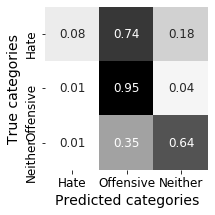

In [14]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=100, test_size=0.1)
# used K=5 fold
logistic_ = Pipeline([('select', SelectFromModel(LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))),
                              ('model', LogisticRegression(C=1, penalty='l1', solver='liblinear'))])
grid_ = GridSearchCV(logistic_, [{}], cv=StratifiedKFold(n_splits=5, random_state=42).split(X_train, y_train),
                             verbose=2)
model = grid_.fit(X_train, y_train)
y_predictions = model.predict(X_test)

# Accuracy
print("Accuracy: ", accuracy_score(y_test, y_predictions) * 100)

# Output Table
output_table = classification_report(y_test, y_predictions)
print(output_table)

# Confusion Matrix
c_matrix = metrics.confusion_matrix(y_test, y_predictions)
generate_confusion_matrix(c_matrix)

Accuracy:  78.2367447595561
              precision    recall  f1-score   support

           0       0.17      0.19      0.18        90
           1       0.88      0.86      0.87      1268
           2       0.56      0.59      0.58       264

    accuracy                           0.78      1622
   macro avg       0.54      0.55      0.54      1622
weighted avg       0.79      0.78      0.79      1622

Confusion Matrix


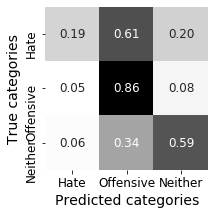

In [15]:
# Decision Tree
decision_tree_entropy = DecisionTreeClassifier(criterion="entropy")
decision_tree_entropy.fit(X_train, y_train)
y_prediction = decision_tree_entropy.predict(X_test)

# Accuracy
print("Accuracy: ", accuracy_score(y_test, y_prediction) * 100)

# Output Table
output_table = classification_report(y_test, y_prediction)
print(output_table)

# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_prediction)
generate_confusion_matrix(cm)

In [16]:
## END OF CODE ##